In [165]:
# Set working directory to the github folder:
setwd("G:\\My Drive\\SDM_China")
library("rstan")
library("raster")
library("gdata")
#library("bayesplot")

In [166]:
path2prod<-"data\\buckwheat_production\\china\\buckwheat_Production.tif"
buckwheat<-raster(path2prod)

In [167]:
# Prepares the raster stack with all the data:
path2env<-"data\\environmental\\china\\"
layers<-list.files(path=path2env,pattern='tif$',full.names=TRUE)
d<-stack(c(buckwheat,layers[c(2,4,9,10,17,18)]))

### Prepare the neighborhood matrix

In [168]:
N<-ncell(d[[1]][!is.na(d[[1]])])

In [169]:
#Get the cell numbers which are not na:
cellnb.na <- Which(!is.na(d[[1]]), cells = TRUE) 
N<-length(cellnb.na);

In [170]:
# This creates a neighbourhood matrix with from and to (but only for cells that are not na, with both source and target cells)
neighbors.mat<-adjacent(d, cells=cellnb.na, directions=8, pairs=TRUE, target=cellnb.na, sorted=TRUE) 
neighbors.mat<-subset(neighbors.mat, neighbors.mat[,2]>neighbors.mat[,1])

In [171]:
N_edges <- nrow(neighbors.mat);
node1 <- neighbors.mat[,1];
node2 <- neighbors.mat[,2];

### Get the values of dependent and independent variable:

In [172]:
data <- as.data.frame(extract(d,cellnb.na))
data$n<-cellnb.na

In [173]:
head(data)

buckwheat_Production,wc2.0_bio_5m_02,wc2.0_bio_5m_04,wc2.0_bio_5m_09,wc2.0_bio_5m_10,wc2.0_bio_5m_17,wc2.0_bio_5m_18,n
0.0000000,14.73733,1745.940,-26.13617,16.49317,13,274,583
0.4329559,14.57542,1729.350,-25.86967,16.35783,13,277,584
0.0000000,15.23158,1753.402,-26.27650,16.60200,14,275,585
0.0000000,15.43192,1760.040,-26.45867,16.68467,13,275,586
0.0000000,15.24217,1753.584,-26.26017,16.62733,13,276,587
0.3112281,14.58842,1747.146,-26.08450,16.55517,14,277,588


# 1. Simple regression model

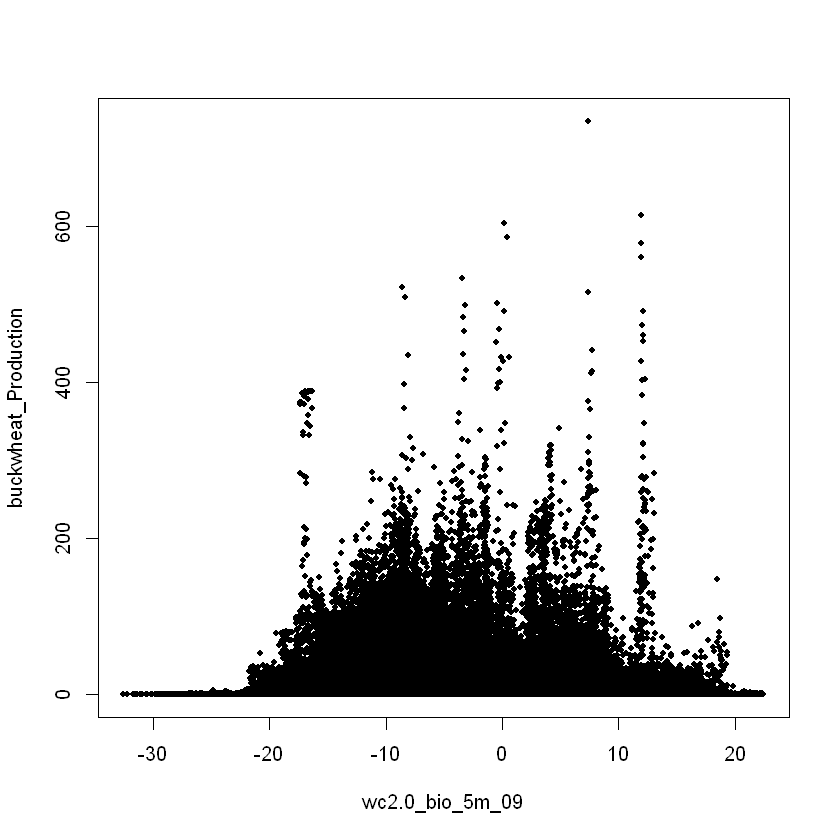

In [174]:
# Plot
plot(buckwheat_Production ~ wc2.0_bio_5m_09, pch = 20, data = data)

In [175]:
lm1 <- lm(buckwheat_Production ~ wc2.0_bio_5m_09, data = data)
summary(lm1)


Call:
lm(formula = buckwheat_Production ~ wc2.0_bio_5m_09, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-18.26 -11.66  -9.31  -4.28 720.63 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     13.177016   0.091803  143.54   <2e-16 ***
wc2.0_bio_5m_09  0.229852   0.007918   29.03   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 29.75 on 136775 degrees of freedom
Multiple R-squared:  0.006124,	Adjusted R-squared:  0.006116 
F-statistic: 842.7 on 1 and 136775 DF,  p-value: < 2.2e-16


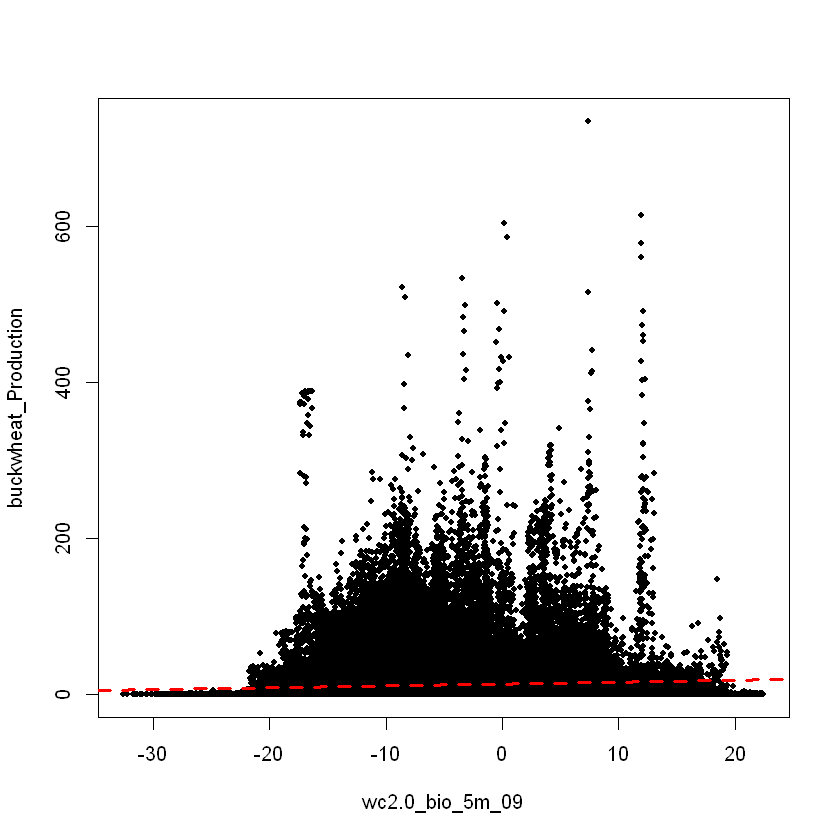

In [176]:
plot(buckwheat_Production ~ wc2.0_bio_5m_09, pch = 20, data = data)
abline(lm1, col = 2, lty = 2, lw = 3)

In [177]:
x <- data$wc2.0_bio_5m_09 # Independent variable - will be an equivalent of temperature, etc.
y <- data$buckwheat_Production # Dependent variable  - equivalent of buckwheat production
N <- nrow(data) # Number of observations

In [178]:
stan_data <- list(N = N, x = x, y = y)

In [179]:
write("// Stan model for simple linear regression

data {
 int < lower = 1 > N; // Sample size is an integer with the lowest value of 1 (i.e. positive)
 vector[N] x; // Predictor is a vector of the size of sample size
 vector[N] y; // Outcome is a vector of a size of sample size
}

parameters {
 real alpha; // Intercept is an unconstrained continous value
 real beta; // Slope (regression coefficients) is an unconstrained continous value
 real < lower = 0 > sigma; // Error SD is an unconstrained positive continous valeu
}

model {
 y ~ normal(alpha + x * beta , sigma); //this seem to declare the model
}
generated quantities {
} // The posterior predictive distribution",

"stan_model1.stan")

In [180]:
stan_model1 <- "stan_model1.stan"

In [181]:
fit <- stan(file = stan_model1, data = stan_data, warmup = 500, iter = 1000, chains = 4, cores = 2, thin = 1)

In [182]:
fit

Inference for Stan model: stan_model1.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean   sd       2.5%        25%        50%        75%
alpha      13.18    0.00 0.09      13.01      13.12      13.18      13.25
beta        0.23    0.00 0.01       0.21       0.23       0.23       0.24
sigma      29.75    0.00 0.06      29.64      29.71      29.75      29.79
lp__  -532460.17    0.04 1.18 -532463.26 -532460.76 -532459.89 -532459.30
           97.5% n_eff Rhat
alpha      13.36   793    1
beta        0.25   908    1
sigma      29.87  2689    1
lp__  -532458.76   904    1

Samples were drawn using NUTS(diag_e) at Mon Sep 23 03:30:20 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [184]:
posterior <- rstan::extract(fit)
str(posterior)

List of 4
 $ alpha: num [1:2000(1d)] 13.2 13.1 13.3 13.4 13.2 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ beta : num [1:2000(1d)] 0.23 0.224 0.23 0.24 0.225 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ sigma: num [1:2000(1d)] 29.8 29.7 29.7 29.7 29.8 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 $ lp__ : num [1:2000(1d)] -532459 -532460 -532461 -532461 -532459 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL


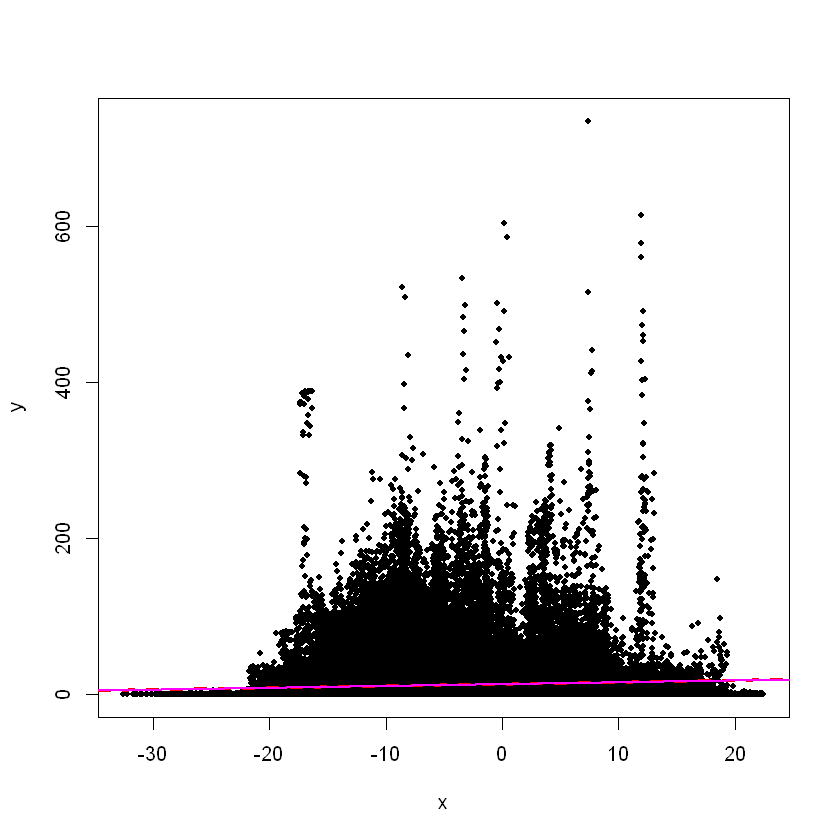

In [185]:
plot(y ~ x, pch = 20)

abline(lm1, col = 2, lty = 2, lw = 3)
abline( mean(posterior$alpha), mean(posterior$beta), col = 6, lw = 2)

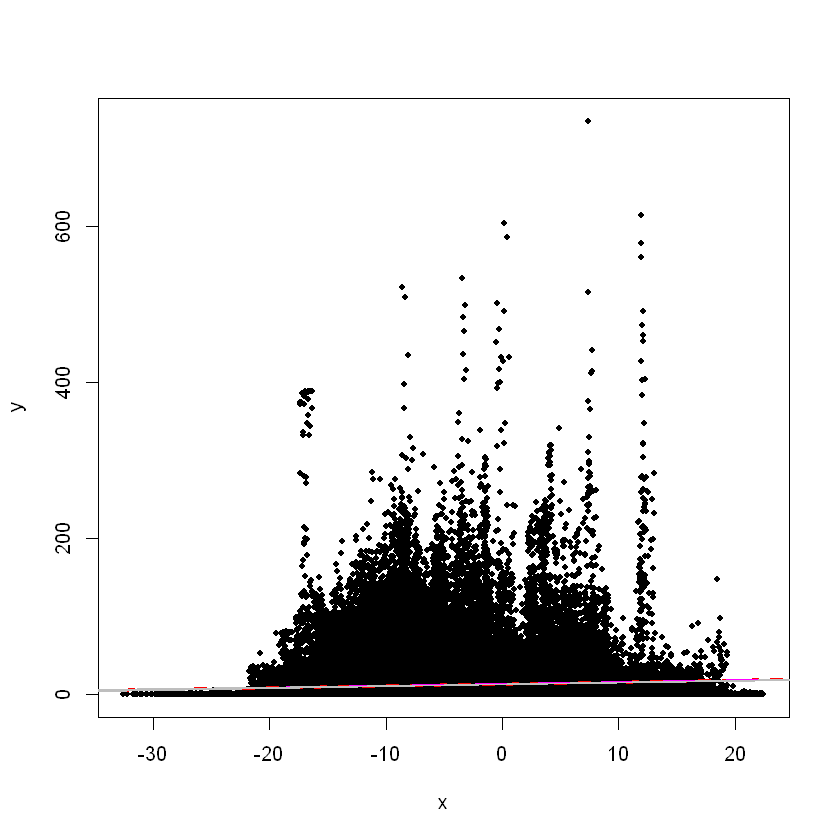

In [188]:
plot(y ~ x, pch = 20)

abline(lm1, col = 2, lty = 2, lw = 3)
abline( mean(posterior$alpha), mean(posterior$beta), col = 6, lw = 2)
for (i in 1:2000) {
 abline(posterior$alpha[i], posterior$beta[i], col = "gray", lty = 1)
}

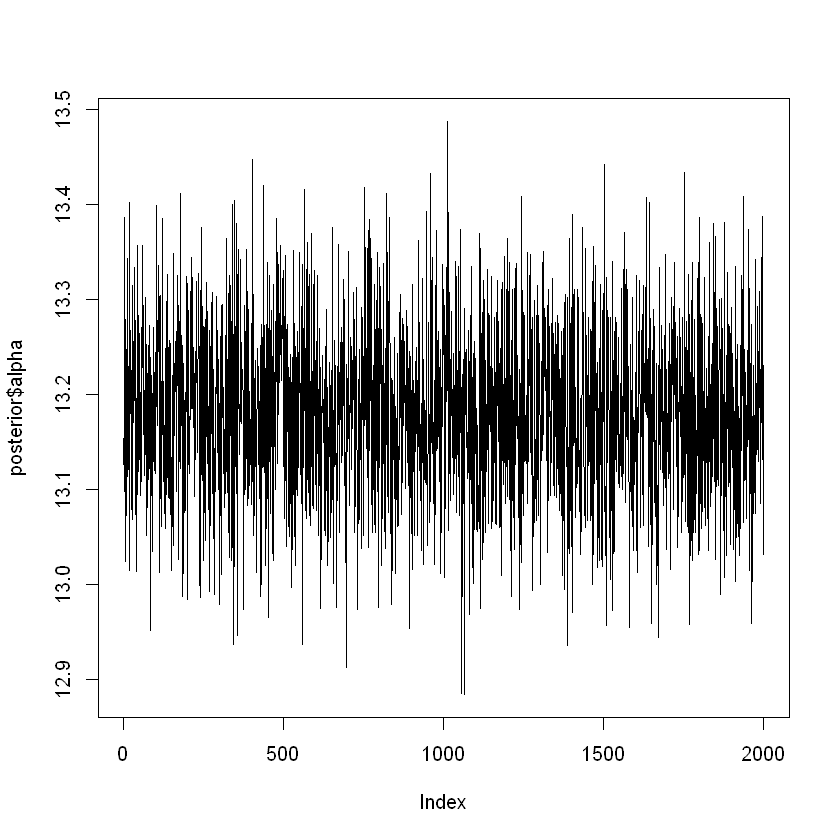

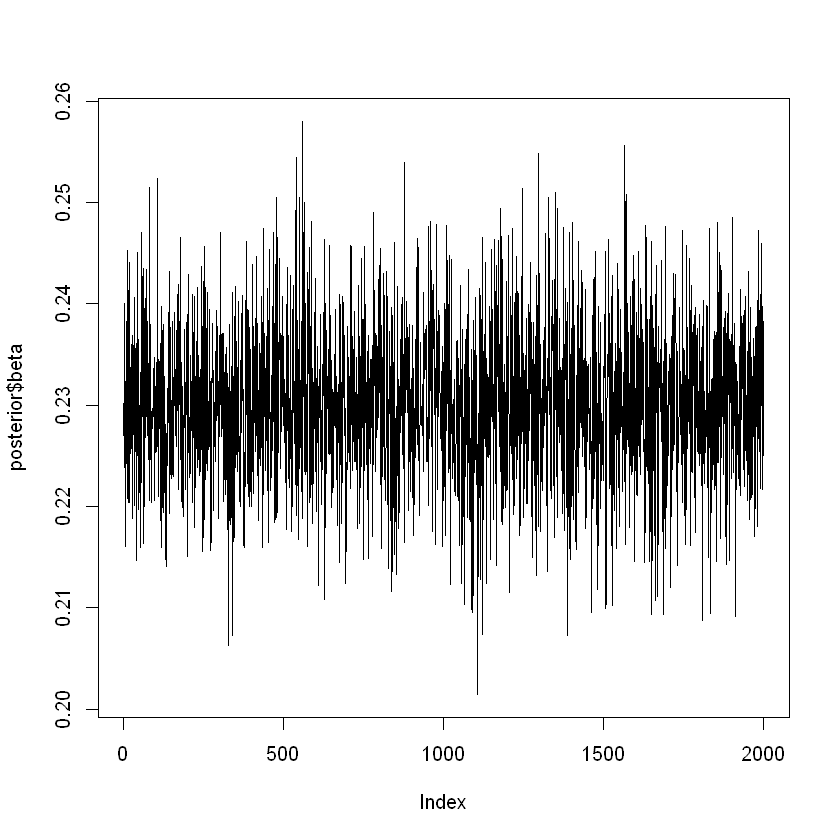

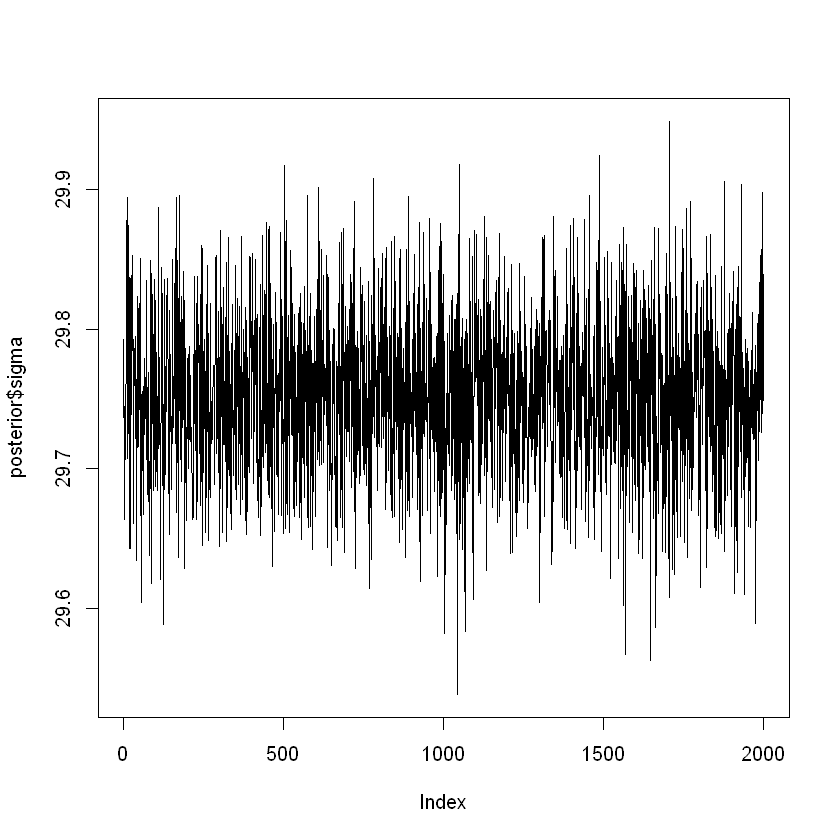

In [211]:
plot(posterior$alpha, type = "l")
plot(posterior$beta, type = "l")
plot(posterior$sigma, type = "l")


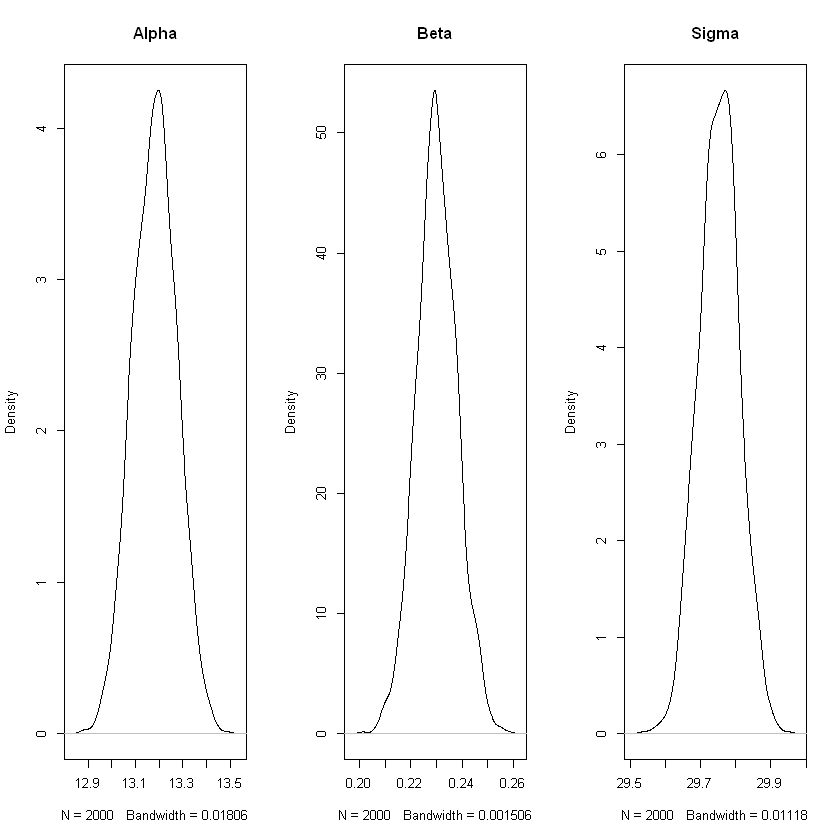

In [213]:
par(mfrow = c(1,3))

plot(density(posterior$alpha), main = "Alpha")
#abline(v = lm_alpha, col = 4, lty = 2)

plot(density(posterior$beta), main = "Beta")
#abline(v = lm_beta, col = 4, lty = 2)

plot(density(posterior$sigma), main = "Sigma")
#abline(v = lm_sigma, col = 4, lty = 2)

In [193]:
writeLines(readLines('stan_models\\simple_iar.stan'))

data {
  int<lower=0> N;
  int<lower=0> N_edges;
  int<lower=1, upper=N> node1[N_edges];  // node1[i] adjacent to node2[i]
  int<lower=1, upper=N> node2[N_edges];  // and node1[i] < node2[i]
}
parameters {
  vector[N] phi;
  real sigma;
}
model {
  target += -0.5 * dot_self(phi[node1] - phi[node2]);

  // soft sum-to-zero constraint on phi,
  // equivalent to mean(phi) ~ normal(0,0.01)
  sum(phi) ~ normal(0, 0.000001 * N);
}


In [207]:
icar_stan = stan_model("stan_models\\simple_iar.stan")

In [208]:
icar_stan

S4 class stanmodel 'simple_iar' coded as follows:
data {
  int<lower=0> N;
  int<lower=0> N_edges;
  int<lower=1, upper=N> node1[N_edges];  // node1[i] adjacent to node2[i]
  int<lower=1, upper=N> node2[N_edges];  // and node1[i] < node2[i]
}
parameters {
  vector[N] phi;
  real sigma;
}
model {
  target += -0.5 * dot_self(phi[node1] - phi[node2]);

  // soft sum-to-zero constraint on phi,
  // equivalent to mean(phi) ~ normal(0,0.01)
  sum(phi) ~ normal(0,0.001);
} 

In [209]:
fit_stan = sampling(icar_stan, data=list(N,N_edges,node1,node1), control=list(adapt_delta = 0.97, stepsize = 0.1), chains=2, warmup=9000, iter=10000, save_warmup=FALSE);

failed to create the sampler; sampling not done


In [205]:
# This can

In [ ]:
N
N_edges
length(node1)

In [ ]:
fit_icar_stan = sampling(icar_stan, data=list(N,N_edges,node1,node2), chains=3, warmup=4000, iter=5000, save_warmup=FALSE)

In [ ]:
N_edges

In [ ]:
length(node1)